# The Final Final Model

 ### Topic : To develop a predictive analytics system for farming that leverages weather forecasting and agricultural data to provide actionable insights. The system will help farmers optimize their agricultural practices, improve crop yield, and enhance sustainability through data-driven decision-making.


### ✅ Cell 1 – Imports

In [1]:
# ==============================
# Cell 1 – Imports
# ==============================

# %pip install catboost scikit-learn seaborn matplotlib pandas lightgbm xgboost

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier


### ✅ Cell 2 – Load All Datasets (Main + Kaggle + Geo)

In [4]:
# ==============================
# Cell 2 – Load Datasets
# ==============================

# 🔥 Adjust paths as per your system
main_path   = "/Users/sayenaqureshi/Main-Folder/datasets/Crop and fertilizer dataset (2).csv"
kaggle_path = "/Users/sayenaqureshi/Main-Folder/datasets/Crop_recommendation (3).csv"
geo_path    = "/Users/sayenaqureshi/Main-Folder/datasets/CropDataset-Enhanced.csv"

df_main = pd.read_csv(main_path)
df_kaggle = pd.read_csv(kaggle_path)
df_geo = pd.read_csv(geo_path)

print("Main dataset shape    :", df_main.shape)
print("Kaggle crop shape     :", df_kaggle.shape)
print("Geo dataset shape     :", df_geo.shape)

print("\nMain columns:", df_main.columns.tolist())
print("\nKaggle columns:", df_kaggle.columns.tolist())
print("\nGeo columns:", df_geo.columns.tolist())


Main dataset shape    : (4513, 11)
Kaggle crop shape     : (2200, 8)
Geo dataset shape     : (730, 23)

Main columns: ['District_Name', 'Soil_color', 'Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Rainfall', 'Temperature', 'Crop', 'Fertilizer', 'Link']

Kaggle columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

Geo columns: ['Address', 'Status geocode', 'Formatted address', 'Latitude', 'Longitude', 'Type', 'Location Type', 'Country', 'Region', 'Crop', 'Nitrogen - High', 'Nitrogen - Medium', 'Nitrogen - Low', 'Phosphorous - High', 'Phosphorous - Medium', 'Phosphorous - Low', 'Potassium - High', 'Potassium - Medium', 'Potassium - Low', 'pH - Acidic', 'pH - Neutral', 'pH - Alkaline', ' ']


### ✅ Cell 3 – Basic Cleaning & Info (Main Dataset)

In [5]:
# ==============================
# Cell 3 – Basic Info & Cleaning on Main Dataset
# ==============================

print("=== Main Dataset Info ===")
print(df_main.info())

print("\n=== Missing values per column ===")
print(df_main.isnull().sum())

# Drop exact duplicates
before = df_main.shape
df_main = df_main.drop_duplicates().reset_index(drop=True)
after = df_main.shape
print(f"\nDropped duplicates: {before} -> {after}")

print("\n=== Unique values per column (Main) ===")
for col in df_main.columns:
    print(f"{col}: {df_main[col].nunique()}")


=== Main Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4513 entries, 0 to 4512
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   District_Name  4513 non-null   object 
 1   Soil_color     4513 non-null   object 
 2   Nitrogen       4513 non-null   int64  
 3   Phosphorus     4513 non-null   int64  
 4   Potassium      4513 non-null   int64  
 5   pH             4513 non-null   float64
 6   Rainfall       4513 non-null   int64  
 7   Temperature    4513 non-null   int64  
 8   Crop           4513 non-null   object 
 9   Fertilizer     4513 non-null   object 
 10  Link           4513 non-null   object 
dtypes: float64(1), int64(5), object(5)
memory usage: 388.0+ KB
None

=== Missing values per column ===
District_Name    0
Soil_color       0
Nitrogen         0
Phosphorus       0
Potassium        0
pH               0
Rainfall         0
Temperature      0
Crop             0
Fertilizer       0
L

### ✅ Cell 4 – Quick EDA (Optional, Good for Viva)

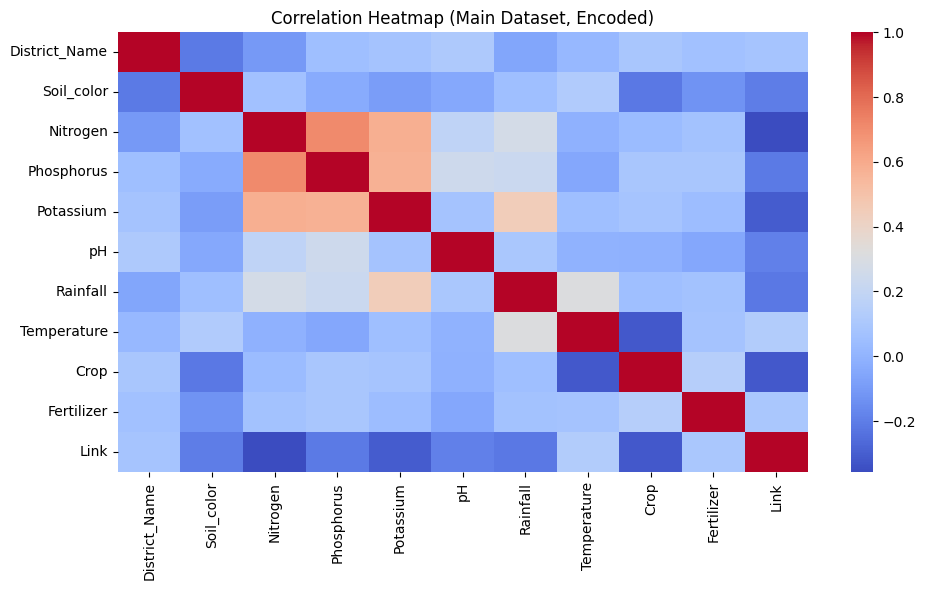

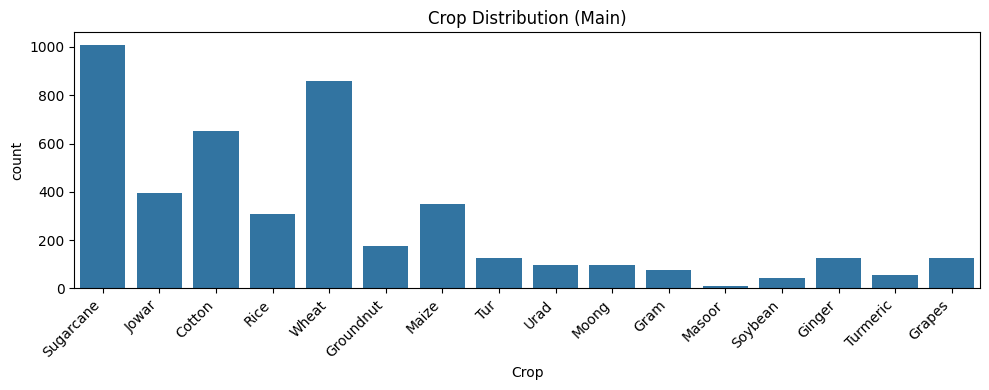

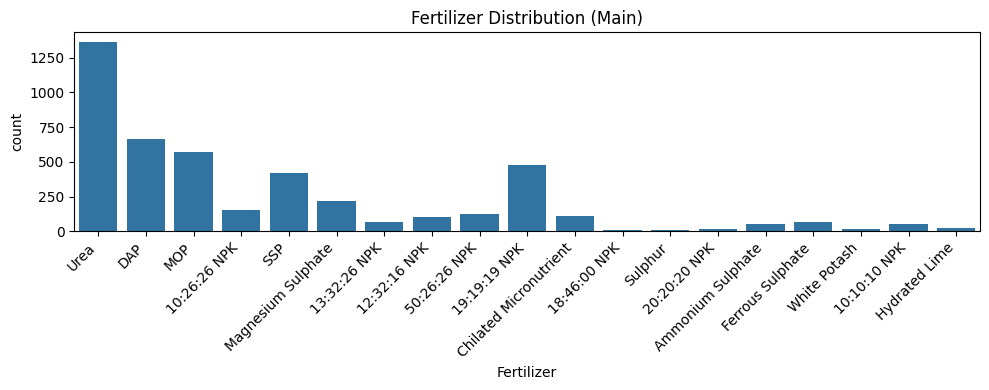

In [6]:
# ==============================
# Cell 4 – Quick EDA (Encoded Correlation + Distribution)
# ==============================

df_enc = df_main.copy()
for col in df_enc.select_dtypes(include="object").columns:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col])

plt.figure(figsize=(10, 6))
sns.heatmap(df_enc.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Main Dataset, Encoded)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(data=df_main, x="Crop")
plt.title("Crop Distribution (Main)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(data=df_main, x="Fertilizer")
plt.title("Fertilizer Distribution (Main)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### ✅ Cell 5 – Prepare Geo Dataset (for Validation Layer)

In [7]:
# ==============================
# Cell 5 – Prepare Geo Dataset (District + Crops)
# ==============================

# Use correct column names from your geo CSV
geo_district_col = "Address"   # e.g., "Address" or "District"
geo_crops_col    = "Crop"      # e.g., "Crop" or "Crops"

df_geo["District_clean"] = (
    df_geo[geo_district_col]
    .astype(str)
    .str.lower()
    .str.strip()
)

df_geo["Crops_clean"] = (
    df_geo[geo_crops_col]
    .astype(str)
    .str.lower()
)

print("Prepared Geo Dataset sample:")
print(df_geo[["District_clean", "Crops_clean"]].head())


Prepared Geo Dataset sample:
                            District_clean  \
0                             ahilya nagar   
1                                    akola   
2                                 amravati   
3  chhatrapati sambhaji nagar, maharashtra   
4                        beed, maharashtra   

                                         Crops_clean  
0  sugarcane, bajra (pearl millet), wheat, cotton...  
1  cotton, soybean, jowar (sorghum), wheat, tur (...  
2  cotton, soybean, jowar (sorghum), wheat, tur (...  
3  cotton, bajra (pearl millet), wheat, sugarcane...  
4  cotton, bajra (pearl millet), wheat, sugarcane...  


### ✅ Cell 6 – Geo Validation Helper

In [8]:
# ==============================
# Cell 6 – Geo Validation Helper
# ==============================

def geo_validate_crop(district_name, predicted_crop, df_geo):
    """
    Returns (status, message)
    status: 'supported', 'unsupported', or 'unknown'
    """
    if district_name is None or predicted_crop is None:
        return "unknown", "No district or crop information available."

    d = str(district_name).lower().strip()
    c = str(predicted_crop).lower().strip()

    matches = df_geo[df_geo["District_clean"].str.contains(d, na=False)]

    if matches.empty:
        return "unknown", f"No geo data available for district '{district_name}'."

    all_crops_text = " , ".join(matches["Crops_clean"].astype(str).tolist())
    crop_list = [x.strip() for x in all_crops_text.split(",") if x.strip()]

    if c in crop_list:
        return "supported", (
            f"The predicted crop '{predicted_crop}' is commonly grown in "
            f"district '{district_name}' according to geo-referenced data."
        )
    else:
        return "unsupported", (
            f"Warning: The predicted crop '{predicted_crop}' is NOT commonly grown in "
            f"district '{district_name}' in geo-referenced data. "
            f"Please consult local experts or consider region-specific constraints."
        )


### ✅ Cell 7 – Build Merged Crop Dataset (Main + Kaggle)

In [10]:
# ==============================
# Cell 7 – Build Merged Crop Dataset
# ==============================

# 1) Align Kaggle columns to our schema
df_kaggle_aligned = df_kaggle.rename(columns={
    "N": "Nitrogen",
    "P": "Phosphorus",
    "K": "Potassium",
    "temperature": "Temperature",
    "humidity": "Humidity",  # unused, but we keep it
    "ph": "pH",
    "rainfall": "Rainfall",
    "label": "Crop"
})

# Add placeholder columns to match our features
df_kaggle_aligned["District_Name"] = "Unknown"
df_kaggle_aligned["Soil_color"]   = "Unknown"

# Keep only required columns for crop model
df_kaggle_crop = df_kaggle_aligned[[
    "Nitrogen", "Phosphorus", "Potassium", "pH",
    "Rainfall", "Temperature", "District_Name", "Soil_color", "Crop"
]]

# 2) Original crop subset from main dataset
df_crop_base = df_main[[
    "Nitrogen", "Phosphorus", "Potassium", "pH",
    "Rainfall", "Temperature", "District_Name", "Soil_color", "Crop"
]].copy()

# 3) Merge main + kaggle
df_crop_merged = pd.concat([df_crop_base, df_kaggle_crop], ignore_index=True)

print("Base crop dataset shape   :", df_crop_base.shape)
print("Kaggle aligned crop shape :", df_kaggle_crop.shape)
print("Merged crop dataset shape :", df_crop_merged.shape)


Base crop dataset shape   : (4513, 9)
Kaggle aligned crop shape : (2200, 9)
Merged crop dataset shape : (6713, 9)


### ✅ Cell 8 – Features, LabelEncoders & Splits (Crop + Fertilizer)

In [11]:
# ==============================
# Cell 8 – Define Features & Encoders (Crop + Fert)
# ==============================

feature_cols = [
    "Nitrogen", "Phosphorus", "Potassium", "pH",
    "Rainfall", "Temperature", "District_Name", "Soil_color"
]

# ---- Crop (Merged Dataset) ----
X_crop = df_crop_merged[feature_cols].copy()
y_crop = df_crop_merged["Crop"].copy()

X_crop["District_Name"] = X_crop["District_Name"].astype(str)
X_crop["Soil_color"]    = X_crop["Soil_color"].astype(str)

cat_features_idx = [
    feature_cols.index("District_Name"),
    feature_cols.index("Soil_color")
]

le_crop = LabelEncoder()
y_crop_le = le_crop.fit_transform(y_crop)

print("Crop classes:", le_crop.classes_)

# Train/test split for merged crop
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_crop, y_crop_le, test_size=0.2, random_state=42, stratify=y_crop_le
)

print("Merged Crop Train/Test shapes:", X_train_c.shape, X_test_c.shape)

# ---- Fertilizer (Original Main Dataset) ----
X_fert = df_main[feature_cols].copy()
y_fert = df_main["Fertilizer"].copy()

# LabelEncoder for Fertilizer
le_fert = LabelEncoder()
y_fert_le = le_fert.fit_transform(y_fert)
print("Fertilizer classes:", le_fert.classes_)

# LabelEncoders for categorical features (fertilizer model)
le_district_f = LabelEncoder()
le_soil_f     = LabelEncoder()

X_fert_enc = X_fert.copy()
X_fert_enc["District_Name"] = le_district_f.fit_transform(
    X_fert_enc["District_Name"].astype(str)
)
X_fert_enc["Soil_color"] = le_soil_f.fit_transform(
    X_fert_enc["Soil_color"].astype(str)
)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fert_enc, y_fert_le, test_size=0.2, random_state=42, stratify=y_fert_le
)

print("Fertilizer Train/Test shapes:", X_train_f.shape, X_test_f.shape)


Crop classes: ['Cotton' 'Ginger' 'Gram' 'Grapes' 'Groundnut' 'Jowar' 'Maize' 'Masoor'
 'Moong' 'Rice' 'Soybean' 'Sugarcane' 'Tur' 'Turmeric' 'Urad' 'Wheat'
 'apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans'
 'mungbean' 'muskmelon' 'orange' 'papaya' 'pigeonpeas' 'pomegranate'
 'rice' 'watermelon']
Merged Crop Train/Test shapes: (5370, 8) (1343, 8)
Fertilizer classes: ['10:10:10 NPK' '10:26:26 NPK' '12:32:16 NPK' '13:32:26 NPK'
 '18:46:00 NPK' '19:19:19 NPK' '20:20:20 NPK' '50:26:26 NPK'
 'Ammonium Sulphate' 'Chilated Micronutrient' 'DAP' 'Ferrous Sulphate'
 'Hydrated Lime' 'MOP' 'Magnesium Sulphate' 'SSP' 'Sulphur' 'Urea'
 'White Potash']
Fertilizer Train/Test shapes: (3610, 8) (903, 8)


### ✅ Cell 9 – CatBoost Training Function (for Crop)

In [12]:
# ==============================
# Cell 9 – CatBoost Training Helper (Crop)
# ==============================

def train_catboost_crop(X_train, X_test, y_train, y_test, cat_features_idx):
    train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)
    valid_pool = Pool(X_test, y_test, cat_features=cat_features_idx)

    model = CatBoostClassifier(
        iterations=400,
        learning_rate=0.05,
        depth=4,
        loss_function="MultiClass",
        eval_metric="TotalF1",
        auto_class_weights="Balanced",
        random_seed=42,
        verbose=False
    )

    model.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True,
        early_stopping_rounds=50
    )
    return model


### ✅ Cell 10 – Train + Evaluate Crop Model (Merged Dataset)

In [13]:
# ==============================
# Cell 10 – Train & Evaluate Crop Model (CatBoost, Merged)
# ==============================

crop_model = train_catboost_crop(
    X_train_c, X_test_c, y_train_c, y_test_c, cat_features_idx
)

# ensure strings
X_test_c["District_Name"] = X_test_c["District_Name"].astype(str)
X_test_c["Soil_color"]    = X_test_c["Soil_color"].astype(str)

y_pred_c = crop_model.predict(X_test_c).flatten().astype(int)

crop_acc = accuracy_score(y_test_c, y_pred_c)
crop_f1  = f1_score(y_test_c, y_pred_c, average="macro")

print("\n=== Crop Prediction – CatBoost (Merged Dataset) ===")
print("Accuracy:", crop_acc)
print("Macro-F1:", crop_f1)

print("\nClassification Report (Crop):")
print(classification_report(
    le_crop.inverse_transform(y_test_c),
    le_crop.inverse_transform(y_pred_c)
))



=== Crop Prediction – CatBoost (Merged Dataset) ===
Accuracy: 0.9717051377513031
Macro-F1: 0.9602919812446001

Classification Report (Crop):
              precision    recall  f1-score   support

      Cotton       0.99      1.00      1.00       130
      Ginger       0.89      1.00      0.94        25
        Gram       0.93      0.81      0.87        16
      Grapes       1.00      1.00      1.00        25
   Groundnut       0.86      0.89      0.87        35
       Jowar       0.96      0.90      0.93        79
       Maize       0.93      1.00      0.97        70
      Masoor       0.50      1.00      0.67         2
       Moong       1.00      1.00      1.00        20
        Rice       1.00      0.97      0.98        62
     Soybean       1.00      1.00      1.00         9
   Sugarcane       1.00      1.00      1.00       202
         Tur       0.81      1.00      0.89        25
    Turmeric       1.00      1.00      1.00        11
        Urad       1.00      1.00      1.00    

### ✅ Cell 11 – Stratified K-Fold for Crop (Merged)

In [14]:
# ==============================
# Cell 11 – Stratified K-Fold (Crop, CatBoost, Merged)
# ==============================

X_all_c = X_crop.copy()
y_all_c = y_crop_le.copy()

X_all_c["District_Name"] = X_all_c["District_Name"].astype(str)
X_all_c["Soil_color"]    = X_all_c["Soil_color"].astype(str)

skf_crop = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_acc_c = []
fold_f1_c  = []

fold_id = 1
for train_idx, val_idx in skf_crop.split(X_all_c, y_all_c):
    X_tr = X_all_c.iloc[train_idx]
    X_va = X_all_c.iloc[val_idx]
    y_tr = y_all_c[train_idx]
    y_va = y_all_c[val_idx]

    model_fold = train_catboost_crop(X_tr, X_va, y_tr, y_va, cat_features_idx)
    y_va_pred = model_fold.predict(X_va).flatten().astype(int)

    acc = accuracy_score(y_va, y_va_pred)
    f1  = f1_score(y_va, y_va_pred, average="macro")

    fold_acc_c.append(acc)
    fold_f1_c.append(f1)

    print(f"Fold {fold_id} – Acc: {acc:.4f}, Macro-F1: {f1:.4f}")
    fold_id += 1

print("\n=== Stratified 5-Fold – Crop (CatBoost, Merged Dataset) ===")
print("Mean Acc  :", np.mean(fold_acc_c), "±", np.std(fold_acc_c))
print("Mean F1   :", np.mean(fold_f1_c), "±", np.std(fold_f1_c))


Fold 1 – Acc: 0.9724, Macro-F1: 0.9648
Fold 2 – Acc: 0.9643, Macro-F1: 0.9542
Fold 3 – Acc: 0.9844, Macro-F1: 0.9830
Fold 4 – Acc: 0.9821, Macro-F1: 0.9734
Fold 5 – Acc: 0.9799, Macro-F1: 0.9752

=== Stratified 5-Fold – Crop (CatBoost, Merged Dataset) ===
Mean Acc  : 0.9766138491465932 ± 0.007361837701169004
Mean F1   : 0.9701373504442229 ± 0.009853224029168259


### ✅ Cell 12 – Train + Evaluate Fertilizer Model (LightGBM, Clean)

In [16]:
# ==============================
# Cell 12 – Train & Evaluate Fertilizer Model (LightGBM, Clean)
# ==============================

fert_model_lgb = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

fert_model_lgb.fit(X_train_f, y_train_f)
y_pred_f = fert_model_lgb.predict(X_test_f)

fert_acc = accuracy_score(y_test_f, y_pred_f)
fert_f1  = f1_score(y_test_f, y_pred_f, average="macro")

print("\n=== Fertilizer Prediction – LightGBM (Clean Data) ===")
print("Accuracy:", fert_acc)
print("Macro-F1:", fert_f1)

print("\nClassification Report (Fertilizer):")
print(classification_report(
    le_fert.inverse_transform(y_test_f),
    le_fert.inverse_transform(y_pred_f)
))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 3610, number of used features: 8
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[L

### ✅ Cell 13 – Stratified K-Fold for Fertilizer (LightGBM, Clean)

In [17]:
# ==============================
# Cell 13 – Stratified K-Fold (Fertilizer, LightGBM, Clean)
# ==============================

X_f_all = X_fert_enc.copy()
y_f_all = y_fert_le.copy()

skf_fert = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_acc_f = []
fold_f1_f  = []

fold_id = 1
for train_idx, val_idx in skf_fert.split(X_f_all, y_f_all):
    X_tr = X_f_all.iloc[train_idx]
    X_va = X_f_all.iloc[val_idx]
    y_tr = y_f_all[train_idx]
    y_va = y_f_all[val_idx]

    model_f = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",
        random_state=42
    )
    model_f.fit(X_tr, y_tr)
    y_va_pred = model_f.predict(X_va)

    acc = accuracy_score(y_va, y_va_pred)
    f1  = f1_score(y_va, y_va_pred, average="macro")

    fold_acc_f.append(acc)
    fold_f1_f.append(f1)

    print(f"Fold {fold_id} – Acc: {acc:.4f}, Macro-F1: {f1:.4f}")
    fold_id += 1

print("\n=== Stratified 5-Fold – Fertilizer (LightGBM, Clean Data) ===")
print("Mean Acc  :", np.mean(fold_acc_f), "±", np.std(fold_acc_f))
print("Mean F1   :", np.mean(fold_f1_f), "±", np.std(fold_f1_f))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 3610, number of used features: 8
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [

### ✅ Cell 14 – Noise Augmentation for Fertilizer + Comparison

In [18]:
# ==============================
# Cell 14 – Noise Augmentation for Fertilizer (Realism Check)
# ==============================

df_noisy_fert = df_main.copy()

noise_config_f = {
    "Nitrogen":   5,
    "Phosphorus": 3,
    "Potassium":  5,
    "pH":         0.3,
    "Rainfall":   80,
    "Temperature":2
}

for col, std in noise_config_f.items():
    df_noisy_fert[col] = df_noisy_fert[col] + np.random.normal(0, std, size=len(df_noisy_fert))

df_noisy_fert["Nitrogen"]    = df_noisy_fert["Nitrogen"].clip(lower=0)
df_noisy_fert["Phosphorus"]  = df_noisy_fert["Phosphorus"].clip(lower=0)
df_noisy_fert["Potassium"]   = df_noisy_fert["Potassium"].clip(lower=0)
df_noisy_fert["pH"]          = df_noisy_fert["pH"].clip(lower=3, upper=9)
df_noisy_fert["Rainfall"]    = df_noisy_fert["Rainfall"].clip(lower=0)
df_noisy_fert["Temperature"] = df_noisy_fert["Temperature"].clip(lower=0, upper=50)

print("Original main shape:", df_main.shape)
print("Noisy fert shape   :", df_noisy_fert.shape)

# Build noisy feature matrix for fertilizer
X_noisy_fert = df_noisy_fert[feature_cols].copy()
y_noisy_fert = le_fert.transform(df_noisy_fert["Fertilizer"])  # labels unchanged

# Use SAME encoders
X_noisy_fert["District_Name"] = le_district_f.transform(
    X_noisy_fert["District_Name"].astype(str)
)
X_noisy_fert["Soil_color"] = le_soil_f.transform(
    X_noisy_fert["Soil_color"].astype(str)
)

X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(
    X_noisy_fert, y_noisy_fert,
    test_size=0.2, random_state=42, stratify=y_noisy_fert
)

noisy_fert_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

noisy_fert_model.fit(X_train_nf, y_train_nf)
y_pred_nf = noisy_fert_model.predict(X_test_nf)

noisy_fert_acc = accuracy_score(y_test_nf, y_pred_nf)
noisy_fert_f1  = f1_score(y_test_nf, y_pred_nf, average="macro")

print("\n=== Fertilizer – LightGBM on Noisy Data ===")
print("Accuracy:", noisy_fert_acc)
print("Macro-F1:", noisy_fert_f1)

# Comparison table clean vs noisy
fert_compare_df = pd.DataFrame([
    ["Fertilizer", "LightGBM – Clean Data", fert_acc,      fert_f1],
    ["Fertilizer", "LightGBM – Noisy Data", noisy_fert_acc, noisy_fert_f1],
], columns=["Target", "Dataset Version", "Accuracy", "Macro-F1"])

print("\n=== Fertilizer – Clean vs Noisy Performance ===")
print(fert_compare_df)


Original main shape: (4513, 11)
Noisy fert shape   : (4513, 11)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 3610, number of used features: 8
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[

### ✅ Cell 15 – Irrigation Logic + Integrated Recommendation API

In [27]:
# ==============================
# Cell 15 – Irrigation Logic + Integrated Recommendation
# ==============================

def irrigation_recommender(crop, rainfall, temp, soil_color):
    high_water_crops = ["Paddy", "Sugarcane", "Grape"]
    low_water_crops  = ["Bajra", "Jowar", "Cotton"]

    if rainfall < 600:
        base_need = "Heavy"
    elif rainfall < 1200:
        base_need = "Moderate"
    else:
        base_need = "Light"

    if crop in high_water_crops and base_need in ["Moderate", "Light"]:
        schedule = "Daily Monitoring (High Volume)"
    elif soil_color in ["Red", "Sandy"] and temp > 30:
        schedule = "Daily Check (Medium Volume)"
    elif crop in low_water_crops and rainfall < 1000:
        schedule = "Weekly Check (Low Volume)"
    else:
        schedule = "Every 2–3 Days"

    return f"{base_need} Irrigation ({schedule})"


def get_full_recommendation(
    input_dict,
    crop_model,
    fert_model_lgb,
    le_crop,
    le_fert,
    le_district_f,
    le_soil_f,
    df_main,
    df_geo
):
    """
    Returns:
      crop, fertilizer, irrigation_advice, link, geo_status, geo_message
    """

    user_df = pd.DataFrame([input_dict])

    # Crop prediction (CatBoost, merged)
    user_df_cat = user_df.copy()
    user_df_cat["District_Name"] = user_df_cat["District_Name"].astype(str)
    user_df_cat["Soil_color"]    = user_df_cat["Soil_color"].astype(str)

    pred_crop_idx = crop_model.predict(user_df_cat).flatten().astype(int)[0]
    pred_crop = le_crop.inverse_transform([pred_crop_idx])[0]

    # Fertilizer prediction (LightGBM, encoded)
    user_df_f = user_df.copy()
    user_df_f["District_Name"] = le_district_f.transform(
        [str(user_df_f["District_Name"].iloc[0])]
    )[0]
    user_df_f["Soil_color"] = le_soil_f.transform(
        [str(user_df_f["Soil_color"].iloc[0])]
    )[0]

    pred_fert_idx = fert_model_lgb.predict(user_df_f)[0]
    pred_fert = le_fert.inverse_transform([pred_fert_idx])[0]

    # Irrigation advice
    irrigation = irrigation_recommender(
        pred_crop,
        float(user_df["Rainfall"].iloc[0]),
        float(user_df["Temperature"].iloc[0]),
        str(user_df["Soil_color"].iloc[0])
    )

    # Link lookup from main dataset
    link_row = df_main[
        (df_main["Crop"] == pred_crop) &
        (df_main["Fertilizer"] == pred_fert)
    ]
    if not link_row.empty and "Link" in link_row.columns:
        link = link_row["Link"].iloc[0]
    else:
        link = "No link available for this combination."

    # Geo validation
    geo_status, geo_msg = geo_validate_crop(
        user_df["District_Name"].iloc[0],
        pred_crop,
        df_geo
    )

    return pred_crop, pred_fert, irrigation, link, geo_status, geo_msg


### ✅ Cell 16 – Simple Test Call (for Debug / Demo)

In [28]:
# ==============================
# Cell 16 – Simple Demo Call
# ==============================

sample_input = {
    "Nitrogen": 150.0,
    "Phosphorus": 68.0,
    "Potassium": 68.0,
    "pH": 6.5,
    "Rainfall": 900.0,
    "Temperature": 28.0,
    "District_Name": "Satara",
    "Soil_color": "Black"
}

crop, fert, irr, link, geo_status, geo_msg = get_full_recommendation(
    sample_input,
    crop_model,
    fert_model_lgb,
    le_crop,
    le_fert,
    le_district_f,
    le_soil_f,
    df_main,
    df_geo
)

print("Input:", sample_input)
print("Predicted Crop      :", crop)
print("Recommended Fertilizer:", fert)
print("Irrigation Advice   :", irr)
print("Link                :", link)
print("Geo Status          :", geo_status)
print("Geo Message         :", geo_msg)


Input: {'Nitrogen': 150.0, 'Phosphorus': 68.0, 'Potassium': 68.0, 'pH': 6.5, 'Rainfall': 900.0, 'Temperature': 28.0, 'District_Name': 'Satara', 'Soil_color': 'Black'}
Predicted Crop      : Sugarcane
Recommended Fertilizer: DAP
Irrigation Advice   : Moderate Irrigation (Daily Monitoring (High Volume))
Link                : https://youtu.be/2t5Am0xLTOo
Geo Status          : supported
Geo Message         : The predicted crop 'Sugarcane' is commonly grown in district 'Satara' according to geo-referenced data.


In [29]:
### 🧩 FINAL Merge + All Models Benchmark (Crop & Fertilizer)
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# ==========================
# 1) Load original main dataset
# ==========================
main_path = "/Users/sayenaqureshi/Main-Folder/datasets/Crop and fertilizer dataset (2).csv"
df_main = pd.read_csv(main_path)

# 8 core features used everywhere
feature_cols = [
    "Nitrogen", "Phosphorus", "Potassium", "pH",
    "Rainfall", "Temperature", "District_Name", "Soil_color"
]

# ==========================
# 2) Load & align Kaggle Crop Dataset (for merging)
# ==========================
crop_reco_path = "/Users/sayenaqureshi/Main-Folder/datasets/Crop_recommendation (3).csv"
df_crop_reco = pd.read_csv(crop_reco_path)

print("Crop Recommendation columns:", df_crop_reco.columns)

df_crop_reco = df_crop_reco.rename(columns={
    "N": "Nitrogen",
    "P": "Phosphorus",
    "K": "Potassium",
    "temperature": "Temperature",
    "humidity": "Humidity",   # not used directly
    "ph": "pH",
    "rainfall": "Rainfall",
    "label": "Crop"
})

df_crop_reco["District_Name"] = "Unknown"
df_crop_reco["Soil_color"]   = "Unknown"

df_crop_reco = df_crop_reco[[
    "Nitrogen","Phosphorus","Potassium","pH",
    "Rainfall","Temperature","District_Name","Soil_color","Crop"
]]

print("Shape of Kaggle crop data:", df_crop_reco.shape)

# ==========================
# 3) Build merged crop dataset (main + kaggle)
# ==========================
df_crop_base = df_main[[
    "Nitrogen","Phosphorus","Potassium","pH",
    "Rainfall","Temperature","District_Name","Soil_color","Crop"
]].copy()

df_crop_merged = pd.concat([df_crop_base, df_crop_reco], ignore_index=True)
print("Merged Crop Dataset Shape:", df_crop_merged.shape)

# ==========================
# 4) CROP – prepare CatBoost and numeric versions
# ==========================
X_crop_cat = df_crop_merged[feature_cols].copy()
y_crop      = df_crop_merged["Crop"].copy()

# CatBoost wants strings for categoricals
X_crop_cat["District_Name"] = X_crop_cat["District_Name"].astype(str)
X_crop_cat["Soil_color"]    = X_crop_cat["Soil_color"].astype(str)

le_crop = LabelEncoder()
y_crop_enc = le_crop.fit_transform(y_crop)

# train/test split using the CatBoost view
X_train_c_cat, X_test_c_cat, y_train_c, y_test_c = train_test_split(
    X_crop_cat, y_crop_enc, test_size=0.2, random_state=42, stratify=y_crop_enc
)

# numeric version for LightGBM / XGBoost
X_crop_num = X_crop_cat.copy()
le_dist_crop = LabelEncoder()
le_soil_crop = LabelEncoder()

X_crop_num["District_Name"] = le_dist_crop.fit_transform(X_crop_num["District_Name"])
X_crop_num["Soil_color"]    = le_soil_crop.fit_transform(X_crop_num["Soil_color"])

# align numeric train/test with same indices
X_train_c_num = X_crop_num.loc[X_train_c_cat.index]
X_test_c_num  = X_crop_num.loc[X_test_c_cat.index]

# categorical indices for CatBoost
cat_idx_crop = [
    X_crop_cat.columns.get_loc("District_Name"),
    X_crop_cat.columns.get_loc("Soil_color")
]

# ==========================
# 5) FERTILIZER – original dataset only
# ==========================
X_fert_cat = df_main[feature_cols].copy()
y_fert      = df_main["Fertilizer"].copy()

X_fert_cat["District_Name"] = X_fert_cat["District_Name"].astype(str)
X_fert_cat["Soil_color"]    = X_fert_cat["Soil_color"].astype(str)

le_fert = LabelEncoder()
y_fert_enc = le_fert.fit_transform(y_fert)

X_train_f_cat, X_test_f_cat, y_train_f, y_test_f = train_test_split(
    X_fert_cat, y_fert_enc, test_size=0.2, random_state=42, stratify=y_fert_enc
)

# numeric view for LightGBM / XGBoost
X_fert_num = X_fert_cat.copy()
le_dist_fert = LabelEncoder()
le_soil_fert = LabelEncoder()

X_fert_num["District_Name"] = le_dist_fert.fit_transform(X_fert_num["District_Name"])
X_fert_num["Soil_color"]    = le_soil_fert.fit_transform(X_fert_num["Soil_color"])

X_train_f_num = X_fert_num.loc[X_train_f_cat.index]
X_test_f_num  = X_fert_num.loc[X_test_f_cat.index]

cat_idx_fert = [
    X_fert_cat.columns.get_loc("District_Name"),
    X_fert_cat.columns.get_loc("Soil_color")
]

# ==========================
# 6) Helper runners
# ==========================
def run_catboost(X_train, X_test, y_train, y_test, cat_idx):
    model = CatBoostClassifier(
        iterations=350,
        learning_rate=0.05,
        depth=6,
        loss_function="MultiClass",
        verbose=False,
        random_seed=42
    )
    model.fit(X_train, y_train, cat_features=cat_idx)
    pred = model.predict(X_test).flatten().astype(int)
    return accuracy_score(y_test, pred), f1_score(y_test, pred, average="macro")

def run_lgbm(X_train, X_test, y_train, y_test):
    model = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",
        random_state=42
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return accuracy_score(y_test, pred), f1_score(y_test, pred, average="macro")

def run_xgb(X_train, X_test, y_train, y_test):
    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return accuracy_score(y_test, pred), f1_score(y_test, pred, average="macro")

# ==========================
# 7) Run models – CROP (merged dataset)
# ==========================
crop_cat_acc, crop_cat_f1 = run_catboost(
    X_train_c_cat, X_test_c_cat, y_train_c, y_test_c, cat_idx_crop
)

crop_lgb_acc, crop_lgb_f1 = run_lgbm(
    X_train_c_num, X_test_c_num, y_train_c, y_test_c
)

crop_xgb_acc, crop_xgb_f1 = run_xgb(
    X_train_c_num, X_test_c_num, y_train_c, y_test_c
)

# ==========================
# 8) Run models – FERTILIZER (original dataset)
# ==========================
fert_cat_acc, fert_cat_f1 = run_catboost(
    X_train_f_cat, X_test_f_cat, y_train_f, y_test_f, cat_idx_fert
)

fert_lgb_acc, fert_lgb_f1 = run_lgbm(
    X_train_f_num, X_test_f_num, y_train_f, y_test_f
)

fert_xgb_acc, fert_xgb_f1 = run_xgb(
    X_train_f_num, X_test_f_num, y_train_f, y_test_f
)

# ==========================
# 9) Final comparison matrix
# ==========================
final_df = pd.DataFrame([
    ["Crop",       "CatBoost (Merged Crop)",   crop_cat_acc,  crop_cat_f1],
    ["Crop",       "LightGBM (Merged Crop)",   crop_lgb_acc,  crop_lgb_f1],
    ["Crop",       "XGBoost (Merged Crop)",    crop_xgb_acc,  crop_xgb_f1],
    ["Fertilizer", "CatBoost (Original Fert)", fert_cat_acc,  fert_cat_f1],
    ["Fertilizer", "LightGBM (Original Fert)", fert_lgb_acc,  fert_lgb_f1],
    ["Fertilizer", "XGBoost (Original Fert)",  fert_xgb_acc,  fert_xgb_f1],
], columns=["Target", "Model", "Accuracy", "Macro-F1"])

print("\n=== FINAL MODEL COMPARISON (Merged Crop + Original Fertilizer) ===")
print(final_df)


Crop Recommendation columns: Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')
Shape of Kaggle crop data: (2200, 9)
Merged Crop Dataset Shape: (6713, 9)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 5370, number of used features: 8
[LightGBM] [Info] Start training from score -3.637586
[LightGBM] [Info] Start training from score -3.637586
[LightGBM] [Info] Start training from score -3.637586
[LightGBM] [Info] Start training from score -3.637586
[LightGBM] [Info] Start training from score -3.637586
[LightGBM] [Info] Start training from score -3.637586
[LightGBM] [Info] Start training from score -3.637586
[LightGBM] [Info] Start training from score -3.637586
[LightGBM] [Info] Sta